In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-segmentation/data/images/274.tif
/kaggle/input/water-segmentation/data/images/123.tif
/kaggle/input/water-segmentation/data/images/130.tif
/kaggle/input/water-segmentation/data/images/170.tif
/kaggle/input/water-segmentation/data/images/66.tif
/kaggle/input/water-segmentation/data/images/296.tif
/kaggle/input/water-segmentation/data/images/215.tif
/kaggle/input/water-segmentation/data/images/116.tif
/kaggle/input/water-segmentation/data/images/204.tif
/kaggle/input/water-segmentation/data/images/171.tif
/kaggle/input/water-segmentation/data/images/18.tif
/kaggle/input/water-segmentation/data/images/232.tif
/kaggle/input/water-segmentation/data/images/168.tif
/kaggle/input/water-segmentation/data/images/125.tif
/kaggle/input/water-segmentation/data/images/216.tif
/kaggle/input/water-segmentation/data/images/233.tif
/kaggle/input/water-segmentation/data/images/94.tif
/kaggle/input/water-segmentation/data/images/86.tif
/kaggle/input/water-segmentation/data/images/256.t

In [2]:
! pip install tifffile

In [3]:
pip install rasterio


Note: you may need to restart the kernel to use updated packages.


In [4]:
!conda install -c conda-forge gdal -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - rapidsai
 - nvidia
 - nodefaults
 - defaults
 - pytorch
Platform: linux-64
Solving environment: - warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       hd4edc92_1         539 KB  conda-forge
    aws-c-auth-0.7.7           |       h4faf3ed_1         100 KB  conda-forge
    aws-c-cal-0.6.9            |       h3b91eb8_1          54 KB  conda-forge
    aws-c-common-0.9.8         |       hd590300_0         220 KB  conda-forge
    aws-c-compression-0.2.17   |       hfd9eb17_6          19 KB  conda-forge
    aws-c-event-stream-0.3.2   |       h1fff966_7          53 KB  conda-forge
    aws-c-http-0.7.14          |       hc86c17

In [2]:
import os
import tifffile as tiff
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

In [3]:

# Directory containing the .tif images
image_dir = "/kaggle/input/water-segmentation/data/images"

# List to store the images
images = []

# Read all .tif images in the directory
for filename in sorted(os.listdir(image_dir)):
    if filename.endswith(".tif"):
        image_path = os.path.join(image_dir, filename)
        image = tiff.imread(image_path)
        images.append(image)
        print(f"Loaded {filename} with shape {image.shape}")

# Convert to numpy array for further processing if needed
images_array = np.stack(images, axis=0)
print(f"All images stacked with shape: {images_array.shape}")

Loaded 0.tif with shape (128, 128, 12)
Loaded 1.tif with shape (128, 128, 12)
Loaded 10.tif with shape (128, 128, 12)
Loaded 100.tif with shape (128, 128, 12)
Loaded 101.tif with shape (128, 128, 12)
Loaded 102.tif with shape (128, 128, 12)
Loaded 103.tif with shape (128, 128, 12)
Loaded 104.tif with shape (128, 128, 12)
Loaded 105.tif with shape (128, 128, 12)
Loaded 106.tif with shape (128, 128, 12)
Loaded 107.tif with shape (128, 128, 12)
Loaded 108.tif with shape (128, 128, 12)
Loaded 109.tif with shape (128, 128, 12)
Loaded 11.tif with shape (128, 128, 12)
Loaded 110.tif with shape (128, 128, 12)
Loaded 111.tif with shape (128, 128, 12)
Loaded 112.tif with shape (128, 128, 12)
Loaded 113.tif with shape (128, 128, 12)
Loaded 114.tif with shape (128, 128, 12)
Loaded 115.tif with shape (128, 128, 12)
Loaded 116.tif with shape (128, 128, 12)
Loaded 117.tif with shape (128, 128, 12)
Loaded 118.tif with shape (128, 128, 12)
Loaded 119.tif with shape (128, 128, 12)
Loaded 12.tif with sha

In [4]:
images_array[0].shape

(128, 128, 12)

In [5]:
def min_max_scaling(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Assuming your array is named images_array with shape (306, 128, 128, 12)
normalized_images_array = min_max_scaling(images_array)

In [6]:
normalized_images_array.shape

(306, 128, 128, 12)

In [7]:
normalized_images_array[0]

array([[[0.39202786, 0.38881579, 0.38978328, ..., 0.39918731,
         0.39005418, 0.3869582 ],
        [0.39245356, 0.38854489, 0.38982198, ..., 0.39918731,
         0.39005418, 0.3869582 ],
        [0.39245356, 0.38889319, 0.39036378, ..., 0.39922601,
         0.3881192 , 0.3869582 ],
        ...,
        [0.39763932, 0.39601393, 0.40441176, ..., 0.39686533,
         0.3873452 , 0.3869582 ],
        [0.39763932, 0.39628483, 0.40549536, ..., 0.39663313,
         0.3873452 , 0.3869582 ],
        [0.39736842, 0.39585913, 0.40305728, ..., 0.39651703,
         0.3873452 , 0.3869582 ]],

       [[0.39365325, 0.39140867, 0.39636223, ..., 0.39934211,
         0.39005418, 0.3869582 ],
        [0.39287926, 0.39102167, 0.39523994, ..., 0.3993808 ,
         0.39005418, 0.3869582 ],
        [0.39287926, 0.39144737, 0.39527864, ..., 0.3994582 ,
         0.3873452 , 0.3869582 ],
        ...,
        [0.3998065 , 0.39883901, 0.40646285, ..., 0.39651703,
         0.3873452 , 0.3869582 ],
        [0.3

# label (mask) images


In [8]:

# Directory containing the .png label images
label_dir = "/kaggle/input/water-segmentation/data/mask"

# List to store the label images
labels = []

# Read all .png label images in the directory
for filename in sorted(os.listdir(label_dir)):
    if filename.endswith(".png"):
        #Remove next line if we wanted to get all 406 -->
        if( '_' in filename.split('.')[0] ): continue
        label_path = os.path.join(label_dir, filename)
        label_image = Image.open(label_path)
        label_array = np.array(label_image)
        labels.append(label_array)
        print(f"Loaded {filename} with shape {label_array.shape}")

# Convert to numpy array for further processing if needed
labels_array = np.stack(labels, axis=0)
print(f"All labels stacked with shape: {labels_array.shape}")
     

Loaded 0.png with shape (128, 128)
Loaded 1.png with shape (128, 128)
Loaded 10.png with shape (128, 128)
Loaded 100.png with shape (128, 128)
Loaded 101.png with shape (128, 128)
Loaded 102.png with shape (128, 128)
Loaded 103.png with shape (128, 128)
Loaded 104.png with shape (128, 128)
Loaded 105.png with shape (128, 128)
Loaded 106.png with shape (128, 128)
Loaded 107.png with shape (128, 128)
Loaded 108.png with shape (128, 128)
Loaded 109.png with shape (128, 128)
Loaded 11.png with shape (128, 128)
Loaded 110.png with shape (128, 128)
Loaded 111.png with shape (128, 128)
Loaded 112.png with shape (128, 128)
Loaded 113.png with shape (128, 128)
Loaded 114.png with shape (128, 128)
Loaded 115.png with shape (128, 128)
Loaded 116.png with shape (128, 128)
Loaded 117.png with shape (128, 128)
Loaded 118.png with shape (128, 128)
Loaded 119.png with shape (128, 128)
Loaded 12.png with shape (128, 128)
Loaded 120.png with shape (128, 128)
Loaded 121.png with shape (128, 128)
Loaded 1

# Data Normalization

In [9]:
def min_max_scaling(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Assuming your array is named images_array with shape (306, 128, 128, 12)
normalized_images_array = min_max_scaling(images_array)

In [10]:
normalized_images_array.shape

(306, 128, 128, 12)

In [11]:
normalized_images_array[0]

array([[[0.39202786, 0.38881579, 0.38978328, ..., 0.39918731,
         0.39005418, 0.3869582 ],
        [0.39245356, 0.38854489, 0.38982198, ..., 0.39918731,
         0.39005418, 0.3869582 ],
        [0.39245356, 0.38889319, 0.39036378, ..., 0.39922601,
         0.3881192 , 0.3869582 ],
        ...,
        [0.39763932, 0.39601393, 0.40441176, ..., 0.39686533,
         0.3873452 , 0.3869582 ],
        [0.39763932, 0.39628483, 0.40549536, ..., 0.39663313,
         0.3873452 , 0.3869582 ],
        [0.39736842, 0.39585913, 0.40305728, ..., 0.39651703,
         0.3873452 , 0.3869582 ]],

       [[0.39365325, 0.39140867, 0.39636223, ..., 0.39934211,
         0.39005418, 0.3869582 ],
        [0.39287926, 0.39102167, 0.39523994, ..., 0.3993808 ,
         0.39005418, 0.3869582 ],
        [0.39287926, 0.39144737, 0.39527864, ..., 0.3994582 ,
         0.3873452 , 0.3869582 ],
        ...,
        [0.3998065 , 0.39883901, 0.40646285, ..., 0.39651703,
         0.3873452 , 0.3869582 ],
        [0.3

# Visualization

# Extract RGB channels

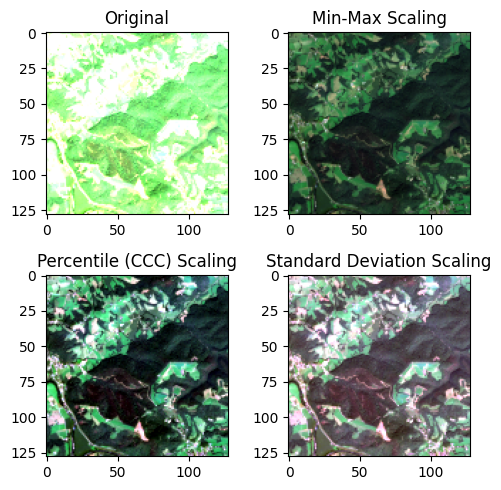

In [21]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

def scaleStd(x):
    return((x - (np.nanmean(x)-np.nanstd(x)*2))/((np.nanmean(x)+np.nanstd(x)*2) - (np.nanmean(x)-np.nanstd(x)*2)))

def scaleMinMax(x):
    return((x - np.nanmin(x))/(np.nanmax(x) - np.nanmin(x)))

# Load the image using GDAL
ds = gdal.Open("/kaggle/input/water-segmentation/data/images/1.tif")

# Extract the RGB channels
r = ds.GetRasterBand(4).ReadAsArray()
g = ds.GetRasterBand(3).ReadAsArray()
b = ds.GetRasterBand(2).ReadAsArray()

ds = None  # Close the dataset

# Apply the scaling functions
rMinMax = scaleMinMax(r)
gMinMax = scaleMinMax(g)
bMinMax = scaleMinMax(b)

rCCC = scaleCCC(r)
gCCC = scaleCCC(g)
bCCC = scaleCCC(b)

rStd = scaleStd(r)
gStd = scaleStd(g)
bStd = scaleStd(b)

# Stack the channels to form RGB images
rgbMinMax = np.dstack((rMinMax, gMinMax, bMinMax))
rgbCCC = np.dstack((rCCC, gCCC, bCCC))
rgbStd = np.dstack((rStd, gStd, bStd))

# Plotting the images in a 2x2 grid
plt.figure(figsize=(5, 5))

# Original image without scaling
plt.subplot(2, 2, 1)
plt.imshow(np.dstack((r, g, b)))
plt.title('Original')

# Min-Max Scaling
plt.subplot(2, 2, 2)
plt.imshow(rgbMinMax)
plt.title('Min-Max Scaling')

# Percentile (CCC) Scaling
plt.subplot(2, 2, 3)
plt.imshow(rgbCCC)
plt.title('Percentile (CCC) Scaling')

# Standard Deviation Scaling
plt.subplot(2, 2, 4)
plt.imshow(rgbStd)
plt.title('Standard Deviation Scaling')

# Adjust layout
plt.tight_layout()
plt.show()

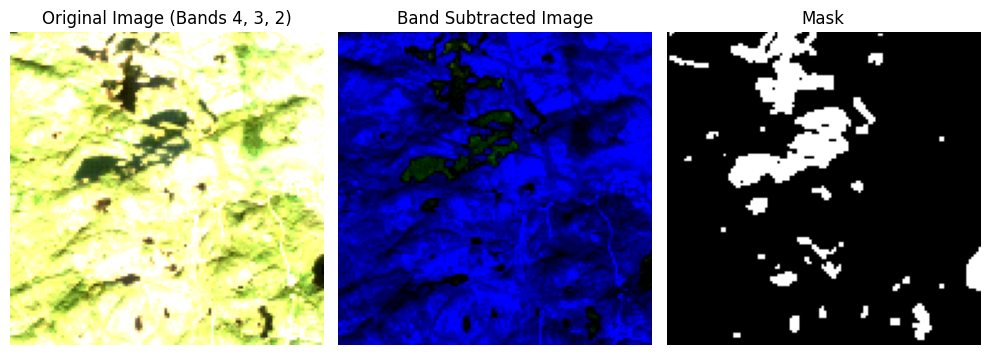

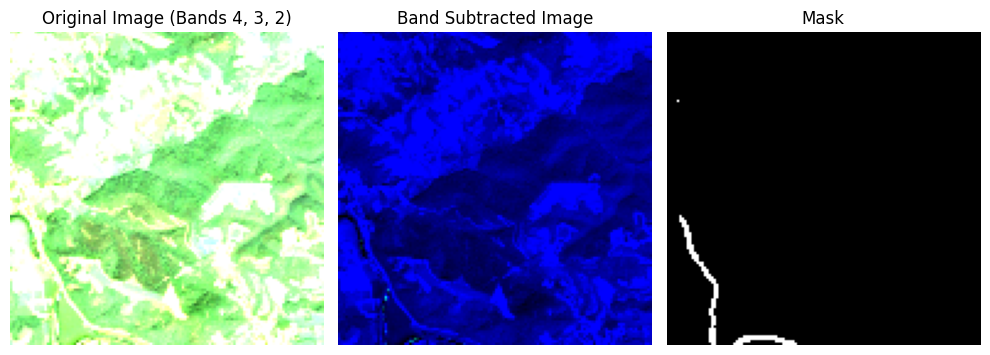

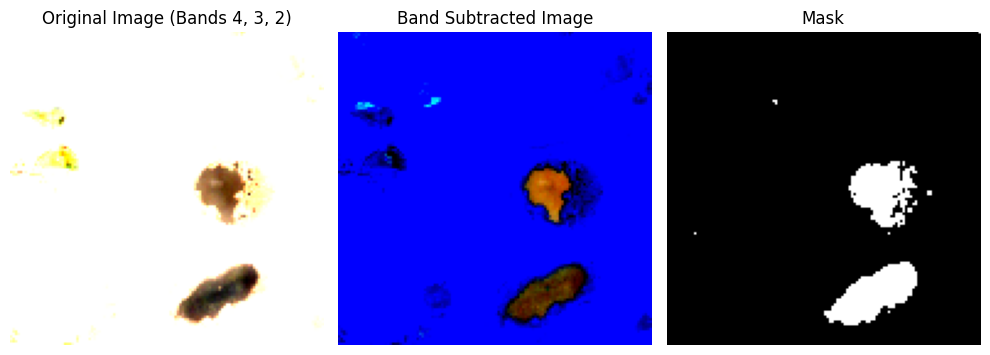

In [22]:
import os
import rasterio
import cv2
import matplotlib.pyplot as plt

# Assuming `images_dir` and `masks_dir` are directories where your .tif and .png files are stored
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

# Loop to visualize images and masks
for i in range(3):  # Visualize the first 3 images
    # Load the image
    image_path = os.path.join(image_dir, image_files[i])
    with rasterio.open(image_path) as src:
        x = src.read()  # Reading all bands

    # Load the mask
    mask_path = os.path.join(label_dir, mask_files[i])
    y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Transpose to make it (Height, Width, Bands)
    x = x.transpose((1, 2, 0))

    # Perform band subtraction
    z = x[:, :, [3, 2, 1]] - x[:, :, [5, 6, 10]]

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    axes[0].imshow(x[:, :, [3, 2, 1]])  # Display original RGB image
    axes[0].set_title("Original Image (Bands 4, 3, 2)")
    axes[0].axis('off')

    axes[1].imshow(z)  # Display the band-subtracted image
    axes[1].set_title("Band Subtracted Image")
    axes[1].axis('off')

    axes[2].imshow(y, cmap='gray')  # Display the mask
    axes[2].set_title("Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Splitting the Data 

In [30]:
data = list(zip(normalized_images_array, labels_array))
np.random.shuffle(data)
inputs, labels = zip(*data)
inputs = np.array(inputs)
labels = np.array(labels)

# Split the data into training, validation, and testing sets
# 70% Training, 15% Validation, 15% Testing
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(inputs, labels, test_size=0.2, random_state=42)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(temp_inputs, temp_labels, test_size=0.5, random_state=42)

# Step 5: Check the shapes of the resulting datasets
print(f"Training set: {train_inputs.shape}, {train_labels.shape}")
print(f"Validation set: {val_inputs.shape}, {val_labels.shape}")
print(f"Test set: {test_inputs.shape}, {test_labels.shape}")

Training set: (244, 128, 128, 12), (244, 128, 128)
Validation set: (31, 128, 128, 12), (31, 128, 128)
Test set: (31, 128, 128, 12), (31, 128, 128)


# **UNET Model**

In [37]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from tensorflow.keras.models import Model

def simplified_unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape
input_shape = (128, 128, 12)

# Create and compile the model
model = simplified_unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128, 128,  │          0 │ conv2d_30[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │     36,928 │ dropout_14[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64, 64,    │          0 │ conv2d_32[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 64,    │    147,584 │ dropout_15[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32, 32,    │          0 │ conv2d_34[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │    590,080 │ dropout_16[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_8[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 16, 16,    │          0 │ conv2d_36[0][0]   │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ dropout_17[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 32, 32,    │    524,544 │ conv2d_37[0][0] 

 Total params: 7,702,529 (29.38 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)

Epoch 1/100


I0000 00:00:1725478449.326485     346 service.cc:145] XLA service 0x58d5d3b69e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725478449.326572     346 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/8 ━━━━━━━━━━━━━━━━━━━━ 3:34 31s/step - accuracy: 0.8064 - loss: 0.6737

I0000 00:00:1725478474.696456     346 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7603 - loss: 0.6291 - val_accuracy: 0.7035 - val_loss: 0.5973
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7615 - loss: 0.5419 - val_accuracy: 0.7035 - val_loss: 0.5945
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7615 - loss: 0.5443 - val_accuracy: 0.7035 - val_loss: 0.5719
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7615 - loss: 0.5238 - val_accuracy: 0.7035 - val_loss: 0.5423
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7615 - loss: 0.4962 - val_accuracy: 0.8503 - val_loss: 0.5478
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8105 - loss: 0.4768 - val_accuracy: 0.8417 - val_loss: 0.4286
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8354 - loss: 0.4076 - val_accuracy: 0.8628 - val_loss: 0.4247
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8796 - loss: 0.3643 - val_accuracy: 0.8866 - val_loss: 0.341

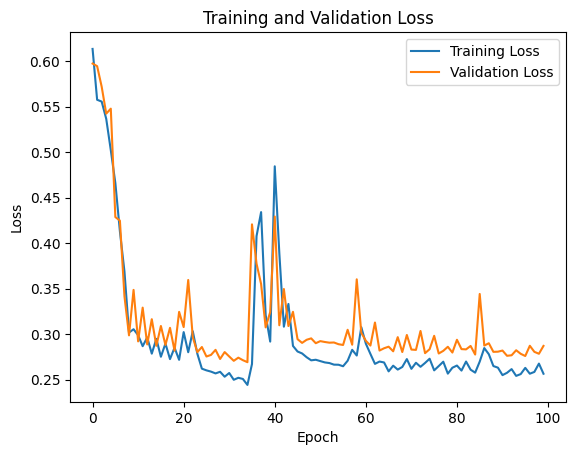

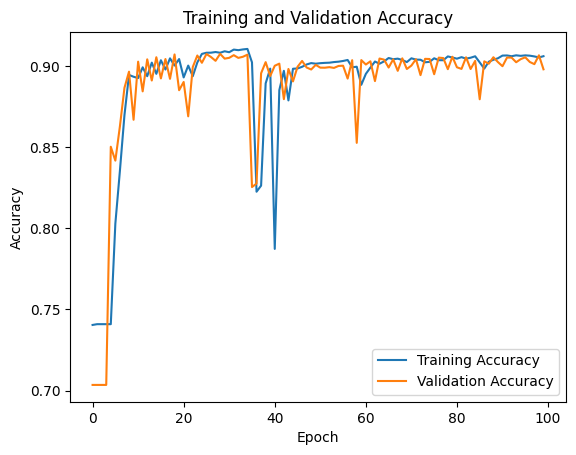

In [39]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D 
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [50]:
# Save the model to a .h5 file
model.save('unet_model.h5')


In [55]:
from IPython.display import FileLink

# Create a clickable link to download 'CNN.h5'
FileLink('unet_model.h5')

/kaggle/working/unet_model.h5

In [40]:
# Make predictions on the test data
predictions = model.predict(test_ds)

# Optionally, check the shape of predictions
print(f"Predictions shape: {predictions.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
Predictions shape: (31, 128, 128, 1)


In [41]:
# Convert predictions to binary if needed (assuming binary classification)
predictions_binary = (predictions > 0.5).astype(np.uint8)

# Flatten the arrays to calculate metrics
y_true = np.concatenate([y.flatten() for y in test_labels], axis=0)
y_pred = np.concatenate([y.flatten() for y in predictions_binary], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9146630071824596


# **Evaluation**

# 1)IoU

In [42]:
# Calculate IoU Score
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred > 0.5, tf.bool)
    intersection = tf.reduce_sum(tf.cast(y_true & y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true | y_pred, tf.float32))
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou
iou_scores = []
for true, pred in zip(test_labels, predictions):
    iou_scores.append(iou_metric(true, pred).numpy())

mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou}")

Mean IoU: 0.14183364808559418


# 2) Confusion Matrix, Precision, Recall, and F1 Score

In [43]:
# Assuming binary segmentation (foreground vs background)
y_true = np.concatenate([y for y in test_labels], axis=0).flatten()
y_pred = np.concatenate([np.round(y) for y in predictions], axis=0).flatten()

# Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Confusion Matrix:
[[380763  11285]
 [ 32058  83798]]
Precision: 0.8813142202076081
Recall: 0.723294434470377
F1 Score: 0.7945235352400457
